In [2]:
# import os
# from pydub import AudioSegment

# input_root = "audio"
# output_root = "audio_wav"

# for subdir in os.listdir(input_root):
#     input_subdir = os.path.join(input_root, subdir)
#     output_subdir = os.path.join(output_root, subdir)

#     if not os.path.isdir(input_subdir):
#         continue

#     os.makedirs(output_subdir, exist_ok=True)

#     for filename in os.listdir(input_subdir):
#         if filename.endswith(".mp3"):
#             input_path = os.path.join(input_subdir, filename)
#             output_path = os.path.join(output_subdir, filename.replace(".mp3", ".wav"))

#             try:
#                 audio = AudioSegment.from_mp3(input_path)
#                 audio = audio.set_channels(1).set_frame_rate(32000)
#                 audio.export(output_path, format="wav")
#             except Exception as e:
#                 print(f"⚠️ Failed to convert: {input_path}")
#                 print(f"   Reason: {e}")


In [3]:
import pandas as pd

# Load the uploaded CSV file
csv_path = "./annotations_final.csv"
df = pd.read_csv(csv_path, sep="\t")

# Display the first few rows to understand its structure
df.head(10)

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
5,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-30-59.mp3
6,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-175-204.mp3
7,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
8,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-291-320.mp3
9,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...


In [4]:
# size of the dataset
print(f"Dataset size: {len(df)} rows")

Dataset size: 25863 rows


In [70]:
import json

# Get the tag columns (all except clip_id and mp3_path)
tag_columns = df.columns.difference(['clip_id', 'mp3_path'])

# Output list
samples = []

for _, row in df.iterrows():
    tags = [tag.replace("_", " ") for tag in tag_columns if row[tag] == 1]
    if not tags:
        continue  # skip samples with no tags
    
    # Generate simple natural language prompt
    prompt = f"A music clip with " + ", ".join(tags[:-1]) + (" and " + tags[-1] if len(tags) > 1 else tags[0]) + "."

    samples.append({
        "audio_filepath": f"audio_wav/{row['mp3_path'].replace('.mp3', '.wav')}",
        "text": prompt
    })

# Save to JSONL
jsonl_path = "./audio_wav/magnatagatune_text_audio_pairs.jsonl"
with open(jsonl_path, "w") as f:
    for sample in samples:
        f.write(json.dumps(sample) + "\n")

jsonl_path

'./audio_wav/magnatagatune_text_audio_pairs.jsonl'

In [71]:
from transformers import EncodecModel, AutoProcessor
import librosa
import torch
import json
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EncodecModel.from_pretrained("facebook/encodec_32khz").to(device)
processor = AutoProcessor.from_pretrained("facebook/encodec_32khz")

input_jsonl = "audio_wav/magnatagatune_text_audio_pairs.jsonl"
output_jsonl = "audio_wav/magnatagatune_tokenized_32khz.jsonl"
Path(input_jsonl).parent.mkdir(parents=True, exist_ok=True)
Path(output_jsonl).parent.mkdir(parents=True, exist_ok=True)

MAX_SAMPLES = 1000

with open(input_jsonl, "r") as fin, open(output_jsonl, "w") as fout:
    for idx, line in enumerate(fin):
        if idx >= MAX_SAMPLES:
            break

        item = json.loads(line)
        audio_path = item["audio_filepath"]

        try:
            waveform, sr = librosa.load(audio_path, sr=None, mono=True)
            # print(f"Processing {audio_path} with shape {waveform.shape} and sample rate {sr}")
            inputs = processor(raw_audio=waveform, sampling_rate=sr, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                codes = outputs.audio_codes[0].cpu().tolist()

            item["audio_tokens"] = codes
            fout.write(json.dumps(item) + "\n")
        except Exception as e:
            print(f"⚠️ Failed on {audio_path}: {e}")

output_jsonl


'audio_wav/magnatagatune_tokenized_32khz.jsonl'

In [72]:
from transformers import AutoTokenizer, AutoModel
import json

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = AutoModel.from_pretrained("bert-base-uncased")
text_encoder.eval()

input_path = "audio_wav/magnatagatune_tokenized_32khz.jsonl"
output_path = "audio_wav/flattened_token_with_text_embedding.jsonl"

Path(output_path).parent.mkdir(parents=True, exist_ok=True)

MAX_SAMPLES = 1000

with open(input_path, "r") as fin, open(output_path, "w") as fout:
    for idx, line in enumerate(fin):
        if idx >= MAX_SAMPLES:
            break

        item = json.loads(line)
        text = item["text"]
        tokens = item["audio_tokens"] 

        try:
            transposed = list(zip(*tokens)) 
            flattened = [tok for frame in transposed for tok in frame] 

            with torch.no_grad():
                encoded = tokenizer(text, return_tensors="pt")
                embedding = text_encoder(**encoded).last_hidden_state.mean(dim=1).squeeze().tolist()

            fout.write(json.dumps({
                "text": text,
                "text_embedding": embedding,
                "audio_flat_tokens": flattened
            }) + "\n")
        except Exception as e:
            print(f"Failed on sample {idx}: {e}")

output_path

'audio_wav/flattened_token_with_text_embedding.jsonl'

In [5]:
from torch.utils.data import Dataset
from typing import List

# 定义 Dataset 类
class MusicGenDataset(Dataset):
    def __init__(self, jsonl_path: str, max_audio_tokens: int = 1024):
        self.data = []
        with open(jsonl_path, "r") as f:
            for line in f:
                item = json.loads(line)
                audio_tokens = item["audio_flat_tokens"][:max_audio_tokens]
                text_embed = item["text_embedding"]

                embed_dim = 768
                num_text_tokens = 8
                if len(text_embed) != embed_dim:
                    continue

                text_tokens = torch.tensor(text_embed, dtype=torch.float).repeat(num_text_tokens, 1)
                text_token_ids = torch.full((num_text_tokens,), -100)

                MAX_AUDIO_TOKENS = 2048
                flat_audio = [tok for frame in zip(*audio_tokens) for tok in frame]
                flat_audio = flat_audio[:MAX_AUDIO_TOKENS + 1]
                input_ids = torch.tensor(flat_audio[:-1], dtype=torch.long)
                labels    = torch.tensor(flat_audio[1:], dtype=torch.long) 

                self.data.append({
                    "text_embed": text_tokens,         # shape: [N_text, 768]
                    "input_ids": input_ids,            # shape: [T]
                    "labels": labels,                  # shape: [T]
                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 构建 Dataset 并保存用于训练
dataset_path = "audio_wav/flattened_token_with_text_embedding.jsonl"
dataset = MusicGenDataset(dataset_path)

# 保存为 .pt 文件
torch.save(dataset, "audio_wav/musicgen_dataset.pt")
"audio_wav/musicgen_dataset.pt"

NameError: name 'json' is not defined

In [74]:
import torch.nn as nn

class MusicGenTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=768, n_layers=6, n_heads=8):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.prefix_proj = nn.Linear(embed_dim, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=2048, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.lm_head = nn.Linear(embed_dim, vocab_size)

        
    def forward(self, text_embed, input_ids):
        tok_emb = self.token_embedding(input_ids)   # [B, T, 768]
        if tok_emb.dim() == 4:
            tok_emb = tok_emb.squeeze(2)

        prefix = self.prefix_proj(text_embed)       # [B, 8, 768]
        x = torch.cat([prefix, tok_emb], dim=1)     # [B, 8+T, 768]

        attn_mask = torch.triu(torch.ones(x.size(1), x.size(1)), 1).bool().to(x.device)
        out = self.transformer(x, mask=attn_mask)
        return self.lm_head(out[:, prefix.size(1):])  # return only audio token logits

In [75]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
jsonl_path = "audio_wav/flattened_token_with_text_embedding.jsonl"
vocab_size = 2048
embed_dim = 768
max_audio_tokens = 1024
batch_size = 1
num_epochs = 10
lr = 1e-4
max_len = 1024 
# dataset = torch.load("audio_wav/musicgen_dataset.pt", weights_only=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

dataset = MusicGenDataset(jsonl_path, max_audio_tokens=max_audio_tokens)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = MusicGenTransformer(vocab_size=vocab_size, embed_dim=embed_dim)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in loader:
        text_embed = batch["text_embed"].to(device)              # [B, 8, 768]
        input_ids  = batch["input_ids"].to(device)[:, :max_len]  # [B, T]
        labels     = batch["labels"].to(device)[:, :max_len]      # [B, T]

        if labels.max() >= vocab_size:
            print("⚠️ 跳过 batch: label 越界")
            print("📌 部分越界标签:", labels.view(-1)[:10].tolist())
            continue

        with autocast():
            logits = model(text_embed, input_ids)                # [B, T, V]
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                labels.view(-1),
                ignore_index=-100
            )

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")

[Epoch 1] Loss: 7.1979
[Epoch 2] Loss: 6.9828
[Epoch 3] Loss: 6.8514
[Epoch 4] Loss: 6.7196
[Epoch 5] Loss: 6.6385
[Epoch 6] Loss: 6.5949
[Epoch 7] Loss: 6.5074
[Epoch 8] Loss: 6.4112
[Epoch 9] Loss: 6.3638
[Epoch 10] Loss: 6.3032


In [118]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration

processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
gen_model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small").to(device)
inputs = processor(text=["a music clip with guitar"], return_tensors="pt", max_length=4, padding="max_length", truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    text_embed = gen_model.text_encoder(**inputs).last_hidden_state

Config of the text_encoder: <class 'transformers.models.t5.modeling_t5.T5EncoderModel'> is overwritten by shared text_encoder config: T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summ

In [110]:
text_embed.shape

torch.Size([1, 4, 768])

In [119]:
import torchaudio
# text_embed = torch.randn(1, 4, 768).to(device)


input_ids = torch.full((1, 1), fill_value=0, dtype=torch.long).to(device)  # 初始 token

generated = []
max_len = 1000

with torch.no_grad():
    for _ in range(max_len):
        logits = model(text_embed, input_ids)  # [B, T, V]
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)  # greedy
        input_ids = torch.cat([input_ids, next_token], dim=1)
        generated.append(next_token.item())

audio_tokens = input_ids[0, 1:].to(device).tolist()


codec = EncodecModel.from_pretrained("facebook/encodec_32khz").to(device)
processor = AutoProcessor.from_pretrained("facebook/encodec_32khz")

num_codebooks = 4
audio_tokens_tensor = torch.tensor(audio_tokens).view(1, -1)
audio_tokens_tensor = audio_tokens_tensor.expand(num_codebooks, -1).unsqueeze(0).unsqueeze(0).to(device)  # [1, 8, T]
audio_scales = torch.ones((1, num_codebooks), dtype=torch.float32).to(device)

with torch.no_grad():
    print(audio_tokens_tensor.shape, audio_scales.shape)
    wav = codec.decode(audio_tokens_tensor, audio_scales=audio_scales)[0]  # [1, 1, samples]
    wav = wav.squeeze().cpu()

torchaudio.save("output.wav", wav[0].unsqueeze(0), 32000)
print("result saved as output.wav")

torch.Size([1, 1, 4, 1000]) torch.Size([1, 4])
result saved as output.wav


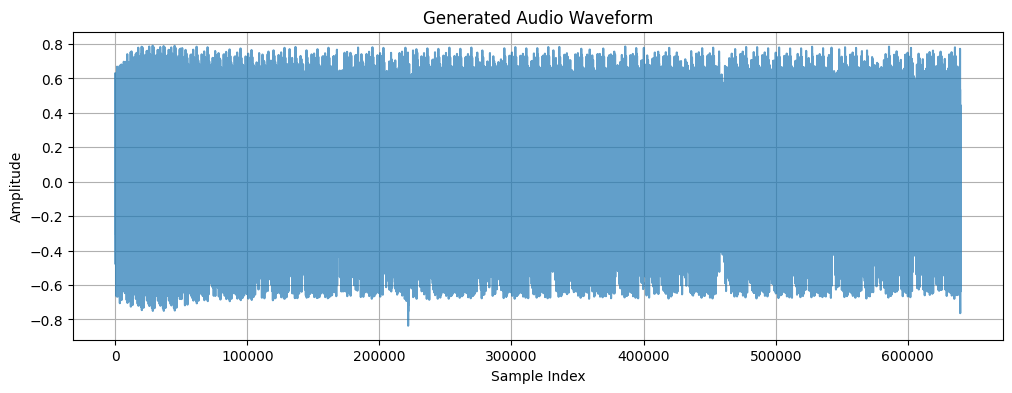

In [120]:
#plot waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(wav[0].numpy(), alpha=0.7)
plt.title("Generated Audio Waveform")
plt.xlabel("Sample Index") 
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Finetune


In [24]:
from transformers import MusicgenForConditionalGeneration, AutoProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small").to(device)
processor = AutoProcessor.from_pretrained("facebook/musicgen-small")

inputs = processor(text=["a classical piano music clip with Japanese anime style"], return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}
audio_values = model.generate(**inputs, do_sample=True, guidance_scale=3, max_new_tokens=256)

Config of the text_encoder: <class 'transformers.models.t5.modeling_t5.T5EncoderModel'> is overwritten by shared text_encoder config: T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summ

In [26]:
import torchaudio
torchaudio.save("output_musicgen.wav", audio_values[0].cpu(), 32000)

In [ ]:
import torch
import torch.nn as nn
from transformers import T5EncoderModel

class StudentGen(nn.Module):
    def __init__(self, vocab_size=2048, d_model=768, n_heads=8, n_layers=8):
        super().__init__()
        self.codebook_emb = nn.Embedding(vocab_size, d_model)
        self.t5 = T5EncoderModel.from_pretrained("t5-small")
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, text_input_ids, text_attn_mask, tokens):
        with torch.no_grad():
            cond = self.t5(input_ids=text_input_ids, attention_mask=text_attn_mask).last_hidden_state

        tgt = self.codebook_emb(tokens)  # [B, T, D]
        tgt = tgt.transpose(0, 1)        # [T, B, D]
        cond = cond.transpose(0, 1)      # [S, B, D]

        out = self.decoder(tgt=tgt, memory=cond)
        out = out.transpose(0, 1)        # [B, T, D]
        logits = self.output_proj(out)
        return logits

In [11]:
def generate(model, tokenizer, prompt, max_len=100, device="cuda"):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        memory = model.t5(**inputs).last_hidden_state.transpose(0, 1)  # [S, B, D]
        generated = [torch.tensor([0], device=device)]  # BOS token or 0

        for _ in range(max_len):
            tgt = torch.stack(generated, dim=1)  # [B, T]
            tgt_emb = model.codebook_emb(tgt).transpose(0, 1)  # [T, B, D]
            out = model.decoder(tgt=tgt_emb, memory=memory).transpose(0, 1)
            logits = model.output_proj(out[:, -1])  # last token
            next_token = logits.argmax(dim=-1)
            generated.append(next_token)
        return torch.stack(generated[1:], dim=1)  # remove BOS


In [18]:
from transformers import EncodecModel, AutoProcessor
import torchaudio

def decode_audio(audio_tokens, output_path="output.wav", sample_rate=32000):
    model = EncodecModel.from_pretrained("facebook/encodec_32khz").to(device)
    processor = AutoProcessor.from_pretrained("facebook/encodec_32khz")

    num_codebooks = 4
    codes = audio_tokens.view(1, -1).expand(num_codebooks, -1).unsqueeze(0).unsqueeze(0).to(device)  # [1, 8, T]
    audio_scales = torch.ones((1, num_codebooks), dtype=torch.float32).to(device)

    with torch.no_grad():
        wav = model.decode(codes, audio_scales=audio_scales)[0]  # [1, 1, samples]
        wav = wav.squeeze().cpu()
        torchaudio.save(output_path, wav, sample_rate)

In [20]:
from transformers import T5Tokenizer

device = "cuda"
model = StudentGen(d_model=512).to(device)
tokenizer = T5Tokenizer.from_pretrained("t5-small")

prompt = "a rock song with electric guitar"
audio_tokens = generate(model, tokenizer, prompt, max_len=1000, device=device)
decode_audio(audio_tokens[0], "output.wav")


In [30]:
from torch.utils.data import Dataset

class TextToAudioTokenDataset(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_audio_len=1024):
        import json
        self.data = []
        with open(jsonl_path, 'r') as f:
            for line in f:
                item = json.loads(line)
                if "text" in item and "audio_tokens" in item:
                    self.data.append(item)
        self.tokenizer = tokenizer
        self.max_audio_len = max_audio_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item["text"], padding="max_length", truncation=True,
            max_length=64, return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 音频 token：pad 到 max_audio_len
        audio_tokens = item["audio_tokens"][:self.max_audio_len]
        pad_len = self.max_audio_len - len(audio_tokens)
        labels = audio_tokens + [0] * pad_len
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(labels, dtype=torch.long)
        }

In [31]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

dataset = TextToAudioTokenDataset("audio_wav/flattened_token_with_text_embedding.jsonl", tokenizer)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # 0是padding
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask, labels)  # [B, T, V]
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")


ValueError: num_samples should be a positive integer value, but got num_samples=0